## Prep

In [1]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [2]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)
with open('sql/300-greenlife-sub-depts.sql', 'r') as query:
        target_item_sub_dept = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-06-25 17:45:00.152587+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-25 17:45:06.215388+10:00 - Saved token with '2025-06-25 21:45:06+10:00' expiry...


## Parameter Tuning

In [327]:
TRX_THRESHOLD = 10 # Min N frequent pairs
QUANTILE = 0.95 # Nth percentile of metric similarity
TOP_N = 5 # top-N associated item classes per primary class
RESO = 1 # >1.0 → more, smaller communities
METRIC = 'LIFT' # LIFT or JACCARD

## Working

In [328]:
filtered_df = df[df['PRIMARY_ID'].isin(target_item_sub_dept['ITEM_SUB_DEPARTMENT_NAME']) & df['SECONDARY_ID'].isin(target_item_sub_dept['ITEM_SUB_DEPARTMENT_NAME'])]

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)

In [329]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
4104,400 BORDERS HEDGING SCREENING,400 TROPICAL,3971,1366,2024-06-01,2025-05-01,15,3.087670,0.002818
7128,400 CACTI AND SUCCULENTS,400 PLANTS OFF RANGE,13191,526,2024-06-01,2025-05-01,15,2.413893,0.001095
43527,400 PLANTS OFF RANGE,400 CACTI AND SUCCULENTS,554,13191,2024-06-01,2025-05-01,15,2.291891,0.001092
55539,400 TROPICAL,400 BORDERS HEDGING SCREENING,1366,3971,2024-06-01,2025-05-01,15,3.087670,0.002818
23709,400 GROUNDCOVER PLANT,400 TROPICAL,4709,1366,2024-06-01,2025-05-01,14,2.430182,0.002310
55590,400 TROPICAL,400 GROUNDCOVER PLANT,1366,4709,2024-06-01,2025-05-01,14,2.430182,0.002310
6732,400 BULBS,400 PLANTS OFF RANGE,13364,526,2024-06-01,2025-03-01,13,2.064959,0.000937
43526,400 PLANTS OFF RANGE,400 BULBS,554,13364,2024-06-01,2025-03-01,13,1.960593,0.000935
4059,400 BORDERS HEDGING SCREENING,400 PALMS,3971,1481,2024-07-01,2025-03-01,12,2.278330,0.002206
23664,400 GROUNDCOVER PLANT,400 PALMS,4709,1481,2024-06-01,2025-05-01,12,1.921267,0.001942


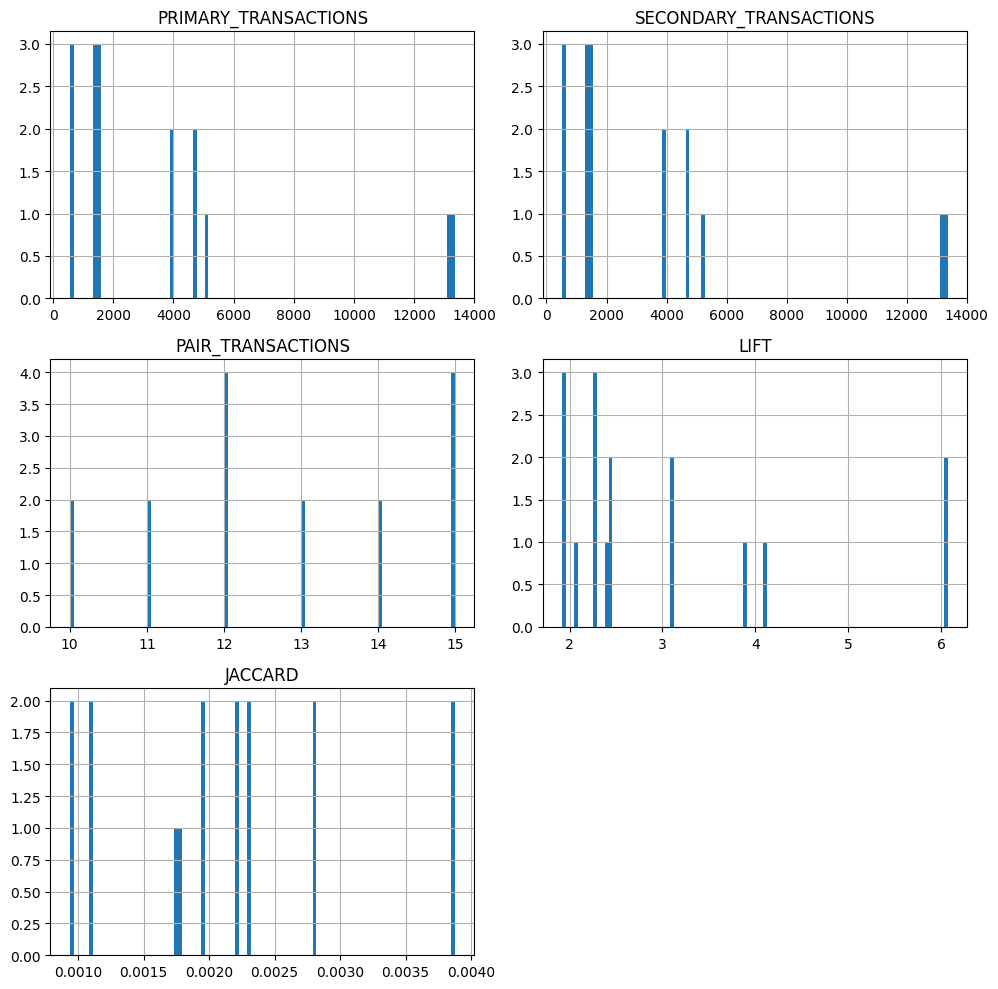

In [330]:
# Plot histograms of numerical columns
numeric_cols = filtered_df.select_dtypes(include='number').columns
filtered_df[numeric_cols].hist(bins=100, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

In [331]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [332]:
fig.show()

In [333]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)

# Expand display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [334]:
display(labelled_df)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,PAIR_TRANSACTIONS,LIFT,segment
0,400 PLANTS OFF RANGE,400 BULBS,554,13364,13,1.960593,0
1,400 BULBS,400 PLANTS OFF RANGE,13364,526,13,2.064959,0
2,400 PLANTS OFF RANGE,400 CACTI AND SUCCULENTS,554,13191,15,2.291891,0
3,400 CACTI AND SUCCULENTS,400 PLANTS OFF RANGE,13191,526,15,2.413893,0
4,400 PLANTS OFF RANGE,400 CLIMBING PLANT,554,5153,10,3.911293,0
5,400 CLIMBING PLANT,400 PLANTS OFF RANGE,5153,526,10,4.119498,0
6,400 GROUNDCOVER PLANT,400 PALMS,4709,1481,12,1.921267,1
7,400 PALMS,400 GROUNDCOVER PLANT,1481,4709,12,1.921267,1
8,400 BORDERS HEDGING SCREENING,400 PALMS,3971,1481,12,2.278330,1
9,400 PALMS,400 BORDERS HEDGING SCREENING,1481,3971,12,2.278330,1


In [337]:
naming = {
    0:  'Feature & Accent Specimens',
    1:  'Mass Landscape Establishment'
}

# Relabel and aggregate
labelled_df['segment'] = labelled_df['segment'].map(naming)

In [338]:
labelled_df.groupby(['segment'], as_index=False).agg(total_PRIMARY_TRANSACTIONS=('PRIMARY_TRANSACTIONS', 'sum')).sort_values('total_PRIMARY_TRANSACTIONS')

,segment,total_PRIMARY_TRANSACTIONS
1,Mass Landscape Establishment,25901
0,Feature & Accent Specimens,33370


In [339]:
labelled_df.groupby(['segment', 'PRIMARY_ID'], as_index=False).agg(total_PRIMARY_TRANSACTIONS=('PRIMARY_TRANSACTIONS', 'sum')).sort_values(['segment', 'total_PRIMARY_TRANSACTIONS'])

,segment,PRIMARY_ID,total_PRIMARY_TRANSACTIONS
3,Feature & Accent Specimens,400 PLANTS OFF RANGE,1662
2,Feature & Accent Specimens,400 CLIMBING PLANT,5153
1,Feature & Accent Specimens,400 CACTI AND SUCCULENTS,13191
0,Feature & Accent Specimens,400 BULBS,13364
7,Mass Landscape Establishment,400 TROPICAL,4098
6,Mass Landscape Establishment,400 PALMS,4443
4,Mass Landscape Establishment,400 BORDERS HEDGING SCREENING,7942
5,Mass Landscape Establishment,400 GROUNDCOVER PLANT,9418


**Feature & Accent Specimens** (Seg 0) 

signals low-volume, high-value orders of off-range, bulbs, succulents and climbers as focal accents.

**Mass Landscape Establishment** (Seg 1) 

highlights large-scale runs of groundcovers, palms, hedging and tropicals used for foundational beds and shade-garden massing.

#